In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
# need to replace this with your own directory
os.chdir(r'/content/drive/My Drive/Colab Notebooks/1512')

# Requirements

In [ ]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
from keras import optimizers
from keras.utils import np_utils
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from keras.regularizers import l2
import cv2

In [ ]:
# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [ ]:
from mnist1d_utils import *

# Dataset

In [ ]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

In [ ]:
x_train = dataset['x']
y_train = dataset['y']
x_test = dataset['x_test']
y_test = dataset['y_test']

In [ ]:
x_train.shape

(4000, 40)

In [ ]:
y_train.shape

(4000,)

Text(0.5, 1.0, 'predicted class: 6')

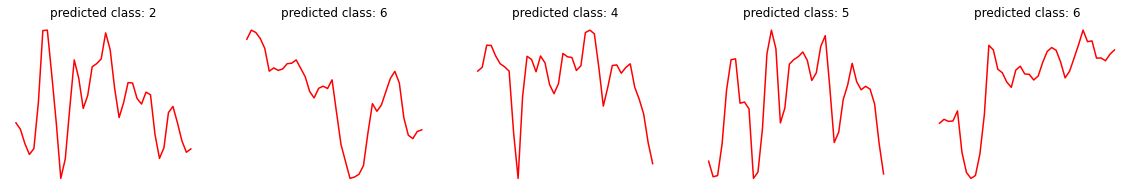

In [ ]:
plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

Text(0.5, 1.0, 'predicted class: 9')

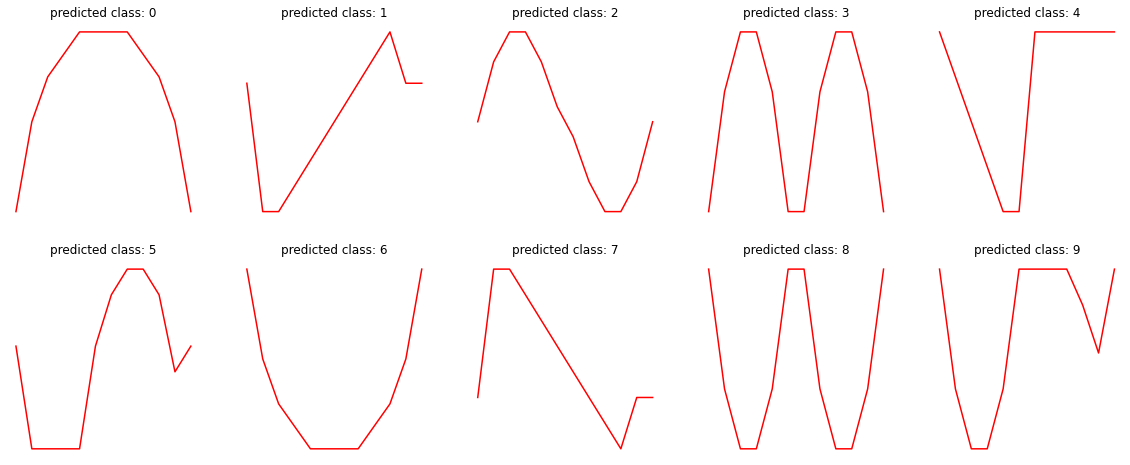

In [ ]:
plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [ ]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()

# Part 1: 1-D Digit Classification

# Task 1: 1-Dimensional digit classification [5 Marks]

# Taks 1-1: Model Creation [1 Marks]

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

In [ ]:
##Task1-Question1
# Implement the Model [1 Marks]

weight_decay = 5e-4
model = Sequential()
#Your code starts from here 

#25*5*5
model.add(Conv1D(filters=25, kernel_size=5, strides=1, padding='same', activation='relu', kernel_regularizer=l2(weight_decay), input_shape=[40,1]))
#25*3*3
model.add(Conv1D(filters=25, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay), activation='relu'))
#25*3*3
model.add(Conv1D(filters=25, kernel_size=3, strides=1, padding='same', kernel_regularizer=l2(weight_decay), activation='relu'))
model.add(Flatten())
model.add(Dense(10, kernel_regularizer=l2(weight_decay), activation='softmax'))
model.summary()

##

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 25)            150       
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________


# Taks 1-2: Training the model [0.5 Marks]

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD) (learning rate = 0.01)

Tensorboard: For recording the training procedure

In [ ]:
# transform data into 4d before feeding to the network
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
y_train = np_utils.to_categorical(y_train, 10)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)
y_test = np_utils.to_categorical(y_test, 10)
#x_train.shape

In [ ]:
##Task1-Question2
# Train the model for 200 epochs [0.5 Marks]
#Your code
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=tensorflow.keras.optimizers.SGD(learning_rate=0.01), metrics=['accuracy'])
tf_callback = keras.callbacks.TensorBoard('./logs', update_freq=1)

# transform data into 4d before feeding to the network
my_model = model.fit(x=np.expand_dims(dataset['x'], axis=-1), y=np_utils.to_categorical(dataset['y'],10), validation_split=0.1, epochs=200)
##

Epoch 1/200
113/113 [==============================] - 2s 7ms/step - loss: 2.3162 - accuracy: 0.1553 - val_loss: 2.2951 - val_accuracy: 0.1500
Epoch 2/200
113/113 [==============================] - 1s 6ms/step - loss: 2.2190 - accuracy: 0.1761 - val_loss: 2.1624 - val_accuracy: 0.1875
Epoch 3/200
113/113 [==============================] - 1s 6ms/step - loss: 2.0357 - accuracy: 0.2286 - val_loss: 1.9656 - val_accuracy: 0.2150
Epoch 4/200
113/113 [==============================] - 1s 5ms/step - loss: 1.8767 - accuracy: 0.2603 - val_loss: 1.8618 - val_accuracy: 0.2625
Epoch 5/200
113/113 [==============================] - 1s 5ms/step - loss: 1.7937 - accuracy: 0.2839 - val_loss: 1.8022 - val_accuracy: 0.2650
Epoch 6/200
113/113 [==============================] - 1s 5ms/step - loss: 1.7459 - accuracy: 0.3125 - val_loss: 1.7618 - val_accuracy: 0.3100
Epoch 7/200
113/113 [==============================] - 1s 5ms/step - loss: 1.7011 - accuracy: 0.3308 - val_loss: 1.7189 - val_accuracy: 0.2975

# Task 1-3a: Plot for loss curve and for accuracy curve. [0.5 Marks]

In [ ]:
print(my_model.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


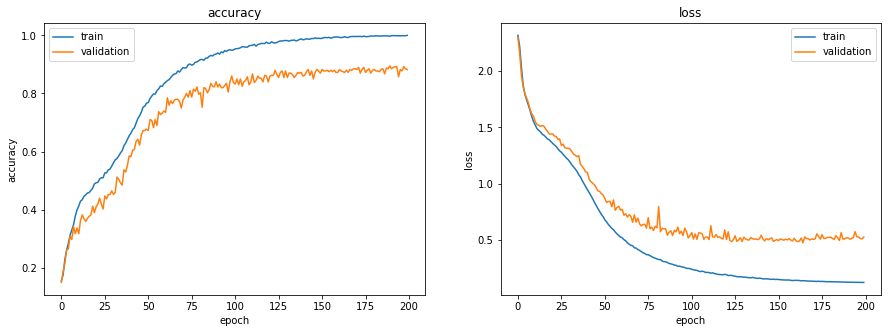

In [ ]:
##Task1-Question3.a
# Plot for loss curve and for accuracy curve. [0.5 Marks]
#Your code
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(my_model.history['accuracy'])
ax[0].plot(my_model.history['val_accuracy'])
ax[0].set_title('accuracy')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('accuracy')
ax[0].legend(['train', 'validation'], loc='upper left')

ax[1].plot(my_model.history['loss'])
ax[1].plot(my_model.history['val_loss'])
ax[1].set_title('loss')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('loss')
ax[1].legend(['train', 'validation'], loc='upper right')

plt.show()
##

# Task 1-3b: Overall classification accuracy on the test set. [0.25 Marks]

In [ ]:
results = model.evaluate(x_test, y_test)
print(f"test loss: {results[0]}, test accuracy: {results[1]}")

32/32 [==============================] - 0s 3ms/step - loss: 0.4804 - accuracy: 0.8930
test loss: 0.4804253876209259, test accuracy: 0.8930000066757202


In [ ]:
# check sklearn version
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.0.2.


# Task 1-3c: Class-wise classification accuracy for all classes. [0.25 Marks]

In [ ]:
# For sklearn>=0.22, confusion_matrix().diagonal() gives per class accuracy
from sklearn.metrics import classification_report
Y_test = np.argmax(y_test, axis=1)
Y_pred = np.argmax(model.predict(x_test), axis=1)
my_confusion_matrix = metrics.confusion_matrix(Y_test, Y_pred, normalize="true")
my_confusion_matrix = my_confusion_matrix.astype('float')/my_confusion_matrix.sum(axis=1)[:, np.newaxis]
my_confusion_matrix.diagonal()
print("class-wise accuracy: (in percentage)\n")
for i in range(10):
  print(str(i) + ": " + str(my_confusion_matrix.diagonal()[i]*100))

class-wise accuracy: (in percentage)

0: 98.0392156862745
1: 81.73076923076923
2: 82.02247191011236
3: 96.22641509433963
4: 87.73584905660378
5: 87.75510204081633
6: 94.94949494949496
7: 86.45833333333334
8: 95.91836734693877
9: 81.37254901960785


# Task 1-3d: Plot the classification ROC and AUC curves for each class. [0.5 Marks]

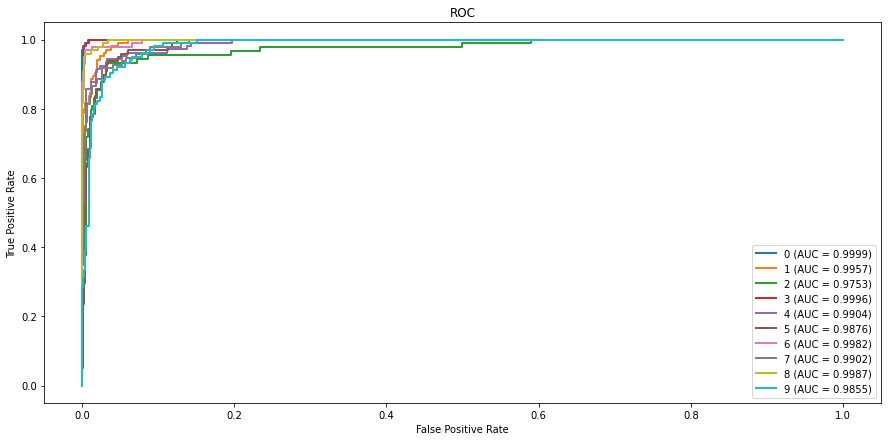

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score


# Binarize the output
y_test = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
y_pred = model.predict(x_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
plt.figure(figsize=(15,7))
lw = 2
for i in range(10):
  plt.plot(fpr[i],tpr[i],lw=lw,label= f"{i} (AUC = %0.4f)" % roc_auc[i])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

In [ ]:
Y_test

array([2, 6, 3, 9, 4, 3, 1, 9, 5, 2, 0, 7, 7, 1, 4, 6, 1, 4, 3, 9, 9, 7,
       5, 0, 7, 1, 7, 6, 9, 7, 8, 0, 4, 3, 8, 9, 4, 1, 1, 0, 1, 5, 7, 4,
       8, 1, 0, 1, 2, 9, 6, 9, 3, 9, 8, 8, 4, 6, 5, 3, 9, 8, 9, 3, 6, 3,
       4, 4, 3, 4, 6, 7, 5, 7, 5, 1, 8, 6, 8, 2, 6, 0, 6, 3, 1, 3, 1, 9,
       2, 7, 5, 3, 9, 5, 7, 2, 1, 0, 7, 6, 6, 7, 2, 9, 2, 9, 6, 5, 9, 0,
       1, 7, 1, 9, 2, 0, 5, 1, 8, 2, 2, 0, 0, 8, 5, 7, 7, 2, 4, 5, 0, 6,
       9, 4, 2, 1, 8, 3, 8, 1, 5, 3, 0, 6, 4, 5, 2, 0, 4, 7, 2, 6, 3, 4,
       9, 9, 6, 6, 8, 0, 7, 6, 7, 0, 6, 5, 4, 2, 0, 6, 3, 2, 8, 1, 6, 0,
       3, 0, 1, 6, 2, 7, 9, 7, 4, 1, 1, 9, 2, 0, 0, 3, 0, 3, 4, 5, 9, 5,
       5, 7, 8, 7, 2, 0, 5, 4, 9, 7, 9, 8, 3, 4, 4, 3, 8, 5, 3, 4, 0, 6,
       1, 5, 4, 9, 1, 1, 2, 6, 8, 3, 5, 1, 2, 5, 5, 1, 0, 8, 3, 9, 6, 1,
       4, 4, 6, 2, 2, 8, 8, 3, 7, 9, 1, 9, 8, 2, 4, 2, 0, 7, 4, 7, 6, 7,
       6, 7, 2, 3, 4, 0, 7, 6, 9, 0, 4, 0, 4, 8, 7, 2, 9, 2, 0, 0, 3, 6,
       8, 5, 4, 8, 8, 5, 6, 8, 6, 4, 6, 9, 5, 5, 8,

In [ ]:
Y_pred

array([2, 6, 3, 9, 4, 3, 9, 9, 5, 2, 0, 7, 7, 1, 4, 6, 2, 9, 3, 2, 9, 7,
       7, 0, 7, 2, 7, 6, 9, 2, 8, 0, 4, 7, 8, 9, 4, 5, 1, 0, 1, 5, 7, 4,
       8, 6, 0, 5, 2, 9, 6, 9, 3, 4, 8, 8, 4, 6, 5, 3, 9, 8, 9, 3, 6, 3,
       4, 4, 3, 4, 6, 7, 5, 7, 5, 1, 8, 6, 8, 2, 6, 0, 6, 3, 1, 3, 1, 9,
       2, 7, 5, 3, 9, 5, 7, 2, 1, 0, 7, 6, 6, 5, 2, 9, 5, 9, 6, 5, 9, 0,
       1, 7, 1, 9, 2, 0, 5, 1, 8, 2, 7, 0, 0, 8, 5, 7, 7, 2, 4, 5, 0, 6,
       4, 4, 2, 1, 8, 3, 8, 1, 5, 3, 0, 6, 4, 5, 2, 0, 4, 7, 2, 6, 3, 4,
       9, 9, 6, 6, 8, 0, 7, 6, 7, 0, 6, 5, 5, 2, 0, 6, 3, 7, 8, 1, 6, 0,
       3, 0, 1, 6, 2, 7, 5, 7, 4, 5, 1, 9, 2, 0, 0, 3, 0, 3, 4, 5, 9, 5,
       5, 7, 8, 7, 2, 0, 5, 9, 9, 7, 9, 8, 3, 4, 4, 3, 8, 5, 3, 4, 0, 6,
       1, 7, 9, 9, 1, 1, 2, 6, 8, 3, 5, 1, 2, 1, 9, 1, 0, 8, 3, 9, 6, 5,
       4, 4, 6, 2, 2, 8, 8, 3, 7, 9, 1, 9, 8, 2, 4, 2, 0, 7, 4, 7, 6, 7,
       6, 7, 2, 3, 9, 7, 3, 6, 5, 0, 4, 0, 4, 8, 5, 4, 9, 2, 0, 0, 3, 6,
       8, 5, 4, 8, 8, 5, 6, 8, 6, 4, 6, 9, 5, 5, 8,

# Task 1-3e: Plot the normalized confusion matrix. [0.25 Marks]


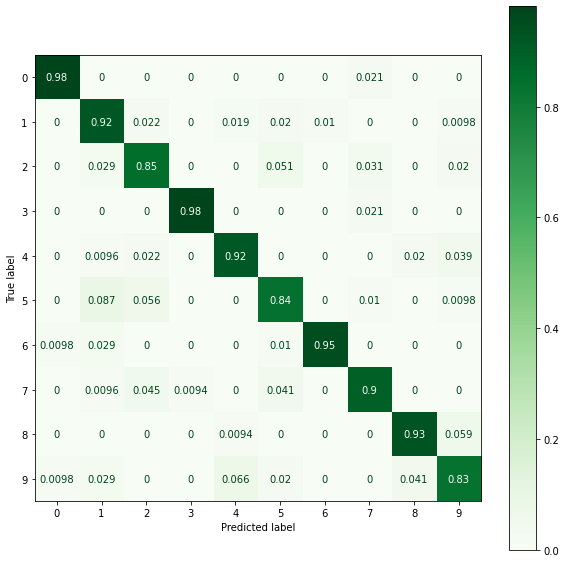

In [ ]:
labels = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9"]
cm = metrics.confusion_matrix(Y_test, Y_pred)
cm = cm/cm.astype(float).sum(axis=1) # normalize
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10)) # adjusting the output plot size
disp.plot(cmap=plt.cm.Greens,ax=ax) # plot
plt.show()

# Task 1-3f: Precision, Recall, and F-1 score on the test set. [0.5 Marks]


In [ ]:
# 3.f Precision, Recall, and F-1 score on the test set. [0.5 Marks]

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       102
           1       0.83      0.92      0.87       104
           2       0.85      0.85      0.85        89
           3       0.99      0.98      0.99       106
           4       0.91      0.92      0.91       106
           5       0.85      0.84      0.85        98
           6       0.99      0.95      0.97        99
           7       0.91      0.90      0.91        96
           8       0.94      0.93      0.93        98
           9       0.86      0.83      0.85       102

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



# Task 1-4: Show some examples of the success/failure cases of the model. Among which two classes misclassification happens the most? Provide your insights and support your answers with analytic reasons. [1.25 Marks]


Text(0.5, 1.0, 'predicted class: 9')

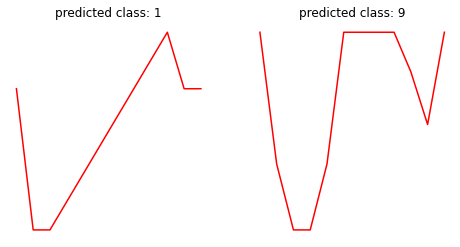

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(8,4))
ax[0].plot(dataset['templates']['x'][1], 'r')
ax[0].axis('off')
ax[0].set_title('predicted class: 1')
ax[1].plot(dataset['templates']['x'][9], 'r')
ax[1].axis('off')
ax[1].set_title('predicted class: 9')

Text(0.5, 1.0, 'true class: 3\npredicted class: 7')

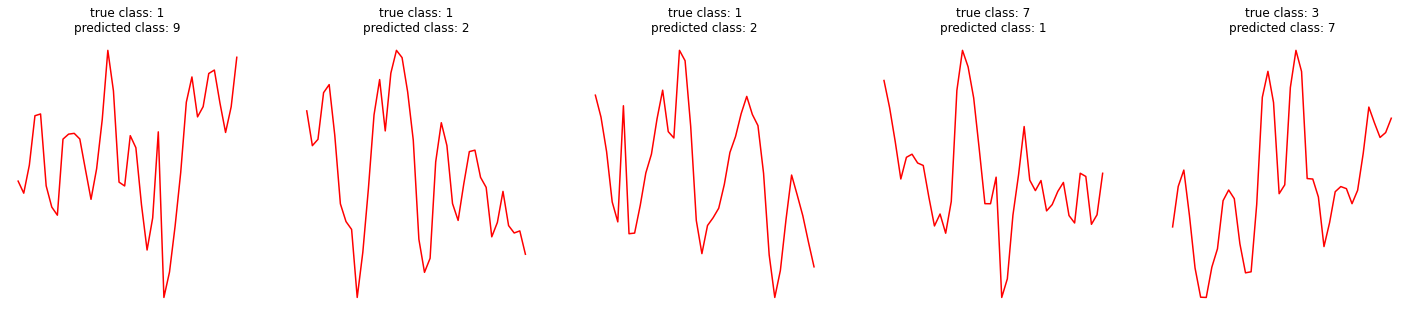

In [ ]:
fig, ax = plt.subplots(1,5,figsize=(25,5))

ax[0].plot(dataset['x_test'][6], 'r')
ax[0].axis('off')
ax[0].set_title('true class: ' + str(dataset['y_test'][6]) + '\n' + 'predicted class: '+str(Y_pred[6]))

ax[1].plot(dataset['x_test'][16], 'r')
ax[1].axis('off')
ax[1].set_title('true class: ' + str(dataset['y_test'][16]) + '\n' + 'predicted class: '+str(Y_pred[16]))

ax[2].plot(dataset['x_test'][25], 'r')
ax[2].axis('off')
ax[2].set_title('true class: ' + str(dataset['y_test'][25]) + '\n' + 'predicted class: '+str(Y_pred[25]))

ax[3].plot(dataset['x_test'][29], 'r')
ax[3].axis('off')
ax[3].set_title('true class: ' + str(dataset['y_test'][29]) + '\n' + 'predicted class: '+str(Y_pred[29]))

ax[4].plot(dataset['x_test'][33], 'r')
ax[4].axis('off')
ax[4].set_title('true class: ' + str(dataset['y_test'][33]) + '\n' + 'predicted class: '+str(Y_pred[33]))

Ranking the classification accuracy from the highest to lowest, we have 0,3,8,1,6,7,4,2,5,9. Therefore, class 0,3, and 8 are the classes that the model most accurately classified, whereas class 9 and 5 have the most misclassifiations. Because the data in the MNIST1D dataset are generated by padding, translating, or transforming the templates, so we will first analyze the cause of misclassifcation by looking at the templates.

Looking at the template patterns, we can conclude that the digits are represented by curves and corners. When randomly padding the images, the corners may get concatenated to one another that causes the model to incorrectly recognize a digit as something else. Because the transformation is random, this randomness can indeed cause the patterns of two different digits look alike, and therefore causing the model to misclassify. Looking at the templates of class 5 and 9, it can be observed that for 9, only half of the shape is captured causing its template look similar to 5's template. With additional random transformation, parts of 9's pattern may look greatly simialr to 5's.

Moreover, the transformation also include adding gaussian noise. Despite that the digit patterns look different in the ideal case (without noise), with the additional noise, some digits may look similar. Again, because noise is random, we cannot really tell what would the transformation results be, and therefore, it is possible for already look-alike classes such as 9 and 5 look even more similar after the transformation and causing the model to misclassify.




# Task 2: CNN interpretation [10 Marks]

# Explanation

In [ ]:
from xai_utils import *

Take a test sample

In [ ]:
x_test = dataset['x_test']
y_test = dataset['y_test']

Give the input to the model (Prediction)

In [ ]:
index = int(np.floor(np.random.rand()*1000))
print(index)
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
print(input.shape)
label = y_test[index]
print(label)
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

486
(1, 40, 1)
3
Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 1.0


## SISE (Semantic Input Sampling for Explanation)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 25)            150       
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# show the explanations in the three conv layer
explanation1 = SISE(input, model, label, [['conv1d']], grad_thr=0.)
explanation2 = SISE(input, model, label, [['conv1d_1']], grad_thr=0.)
explanation3 = SISE(input, model, label, [['conv1d_2']], grad_thr=0.)

# three thresholds in all three conv layers.
threshold1 = np.sort(explanation1[:,0])[-12]
threshold2 = np.sort(explanation2[:,0])[-12]
threshold3 = np.sort(explanation3[:,0])[-12]

In [ ]:
threshold1, threshold2, threshold3

(0.09977858009450276, 0.07541708863131248, 0.13064797552053328)

Text(0.5, 1.0, 'Highlighted input region (by the SISE algorithm)')

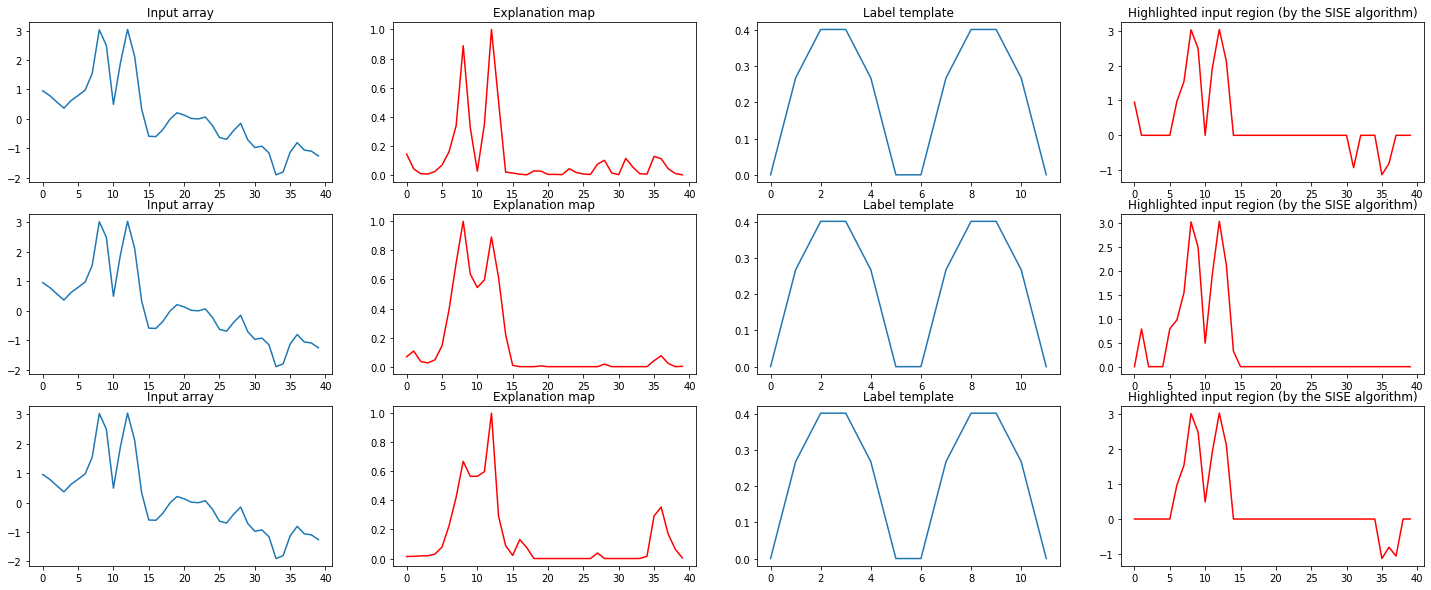

In [ ]:
fig, ax = plt.subplots(3,4,figsize=(25,10))

# we plotted three sets of graphs.
# the graphs in the 1st row shows the explanation in the 1st conv layer (explanation1).
# the graphs in the 2nd row shows the explanation in the 2nd conv layer (explanation2).
# the graphs in the 3rd row shows the explanation in the 3rd conv layer (explanation3).

# plot x_test here
ax[0,0].plot(input[0])
ax[0,0].set_title('Input array')

ax[1,0].plot(input[0])
ax[1,0].set_title('Input array')

ax[2,0].plot(input[0])
ax[2,0].set_title('Input array')

# suppress unimportant feature
ax[0,1].plot(explanation1, 'r')
ax[0,1].set_title('Explanation map')

ax[1,1].plot(explanation2, 'r')
ax[1,1].set_title('Explanation map')

ax[2,1].plot(explanation3, 'r')
ax[2,1].set_title('Explanation map')

# plot the template
ax[0,2].plot(dataset['templates']['x'][label])
ax[0,2].set_title('Label template')

ax[1,2].plot(dataset['templates']['x'][label])
ax[1,2].set_title('Label template')

ax[2,2].plot(dataset['templates']['x'][label])
ax[2,2].set_title('Label template')

# show the most significant template region got highlighted within the layer
ax[0,3].plot((input[0]*(explanation1>threshold1)), 'r')
ax[0,3].set_title('Highlighted input region (by the SISE algorithm)')

ax[1,3].plot((input[0]*(explanation2>threshold2)), 'r')
ax[1,3].set_title('Highlighted input region (by the SISE algorithm)')

ax[2,3].plot((input[0]*(explanation3>threshold3)), 'r')
ax[2,3].set_title('Highlighted input region (by the SISE algorithm)')

Instead of using the Grad-CAM below, we decided to use Grad-CAM++ which is an improved version of Grad-CAM. Along with Grad-CAM++, the second method that we are going to use is Local Interpretable Model-Agnostic Explanations (LIME).

# Task 2-1a (1): What knowledge gap did your two chosen attribution methods fill? [0.5 Marks]

# Grad-CAM++ and LIME

Convolutional Neural Networks (CNN) is a popular method used in many areas. However, in most cases, CNNs have been used as a black box. Whether or not to trust the prediction produced by the model remains skeptical. The lack of transparency makes understanding and interpreting these CNNs difficult. Which feature or which part of the input is activating the neurons might be unknown, and one can hardly tell the detailed things happened within the CNN by just looking at the results. This is true especially for a categorical classifier because by just looking at the output, although the class-wise performance is obvious, it is nearly impossible to give analytical reason that which feature contributes to that prediction or what causes potential misclassification. With the help of these attribution methods, CNNs become transparent, faithfully explanable, and interpretable. One can easily see what's happening inside the CNNs, layer by layer by using these tools. Some explanation models even offer the ability to trace the feature to individual neuron with a given layer.

# Task 2-1a (2): What novelty did they contribute compared to their prior methods? [0.5 Marks]

Because Grad-CAM++ is an improved version of Grad-CAM++, we need to know why is the baseline Grad-CAM better that existing works. Unlike its previous work, Class Activation Mapping (CAM) that can only be used on a CNN without any FC layers, Grad-CAM is a general version that utilize gradient information and can operates on a variety of CNN structures. Because the spatial information will be lost in fully connected layers, Grad-CAM focuses on the last convolutional layer and uses the gradients in this layer to investigate which neuron contributes to a particular decision the most. Grad-CAM also generates a heatmap on the image that highlights the region where the object is located. Compare to other existing works such as guided backpropagation and deconvolution, Grad-CAM is class-discriminative meaning that only class-specific region with be highlighted in the heatmap.

Having what Grad-CAM is in mind, Grad-CAM++ is an improved and more general version of Grad-CAM. Grad-CAM++ is able to localize multiple objects within the same image while mainting a high performance (Grad-CAM does not work well on multiple object images). Grad-CAM++ also fix the problem where Grad-CAM's heatmap often cannot cover the entire object region. Moreover, Grad-CAM++ can be used on spatiotemporal data which Grad-CAM cannot.

Local Interpretable Model-agnostic Explanations (LIME) is another explanation technique that can explain the prediction by understanding what contributes to a particular prediction. LIME provides human-understandable class-wise representaion to explain the model, regardless of what the actual features are. Differ from existing works, LIME uses a locality-aware loss to measure the faithfulness locally. Because LIME uses random sampling from the original training data to generate the data it needs, in other words, the explanation provided by LIME does not greatly depend on the training data in the model that it wants to analyze. Therefore, LIME is model agnostic.

# Task 2-1b: Explain in full detail the methodologies of your selected methods. [2 Marks]

Because Grad-CAM++ is an improved version of Grad-CAM, and Grad-CAM is a more generalized version of CAM, so we first need to fully understand what is CAM and how does the underlying logic work. We will explain the full detail of Grad-CAM++ by first introducing CAM and Grad-CAM.

In Grad-CAM, Assume there are K feature maps produced by the second last layer of the model, let Akij represents the activation at (i,j) in feature map Ak, the feature maps are spatially pooled using global average pooling and linearly transformed to produce a score Yc for each class c. Yc = ∑k wck 1/z ∑i∑j Akij where wck represents the class feature weights. Let the GAP result be Fk and Fk = 1/z∑i∑jAkij, Yc = ∑kwck * Fk. Then, take the gradient of Yc w.r.t Fk, we get dYc/dFk = (dYc/dAkij) / (dFk/dAkij). The partial derivative of Fk w.r.t Akij is 1/z, replacing it in the previous equation, dYc/dFk = (dYc/dAkij) * Z. Because dYc/dFk = wck, wck = Z * dYc/dAkij. Calculate the sum over all pixels, ∑i∑j wck = ∑i∑jZ*dYc/dAkij. Rewritting, we get wck = ∑i∑jdYc/dAkij. This wck is the same as αck used in Grad-CAM. Then the coarse heatmap in Grad-CAM is generated by using L = ReLU(∑kαckAk). The ReLU here is used to capture positive features.

To summarize all the above, Grad-CAM first calcualtes the weights for each pixel that belongs to the c classes in each of the feature map using gradients. Next, a weighted activation for each pixel is calculated within each feature map. Then, the weighted actiavtion are summed together to indicate the pixel-wise importance using a heatmap. Finally, the heatmap is upsampled onto the original image to produce a coarse class/object-wise heatmap. 

In Grad-CAM, spatial information is important. However, if there are multiple objects with different orientations, the objects at each spatial location might be activated into different feature maps. Eventually, the feature map with the least information will disappear in the final heatmap. Grad-CAM++ fixes this issue by calculating the weighted average of pixel-wise gradients. In Grad-CAM++, Yc is calcualted as ∑k{∑a∑bakcab*ReLU(dYc/dAkab)}[∑i∑jAkij]. It is obvious that Grad-CAM++ iterates over the same activation twice by using (a,b) and (i,j) compare to once over (i,j) in Grad-CAM. After taking a series of partial derivatives of dYc/dAkij, αkcij = (d^2Yc/(dAkij)^2)/2*(d^2Yc/(dAkij)^2)+∑a∑bAkab{d^3Yc/(dAkij)^3}. Finally, wck = ∑i∑jαkcij*Relu(dYc/dAkij) that captures the importance of feature map Ak, where αkcij is the weighting coefficient for pixel-wise gradients of class c within feature map Ak.

In the general LIME, the explanation is defined as a Model g ∈ G, where G is a list of all potential interpretable models. g ∈ {0,1} which means the interpretable components are either there or not there. The explanation complexity is defined as Ω(g). Denote the model to be explained as f, f(x) is the prediction on a training sample x. Πx(z) measures the distance between a sample z and x (locality). Finally, L(f,g,Πx) is a loss function that measures how unfaithful is g in approximating f in Πx, and obviously, L needs to be minimized while maintaining low complexity Ω to ensure interpretability and local-fidelity. 

Mathematically, LIME's explanation is calculated using ξ(x) = argmin g∈G L(f,g,Πx) + Ω(g). To study the local behaviour of f and ensure model-agnostic, the non-zero samples are randomly selected from a uniform distributin around x'. Then, a fraction of x' is used to produce z'. z' is then mapped back to the origianl representation to get z and use f(z) to produce label. The new perturbed dataset is denoted as Z. Finally, this Z is used to mininize ξ.

If the models in G are linear, g(z') = wg * z' and the loss function (square loss becomes L(f,g,Πx) = ∑z,z'∈Z Πx(z)(f(z)-g(z'))^2. The exponential kernel is defined as Πx(z) = exp(-D(x,z)^2/σ^2) where D is a distance function such as L2 distance and σ is the kernel width. Ω(g) = ∞1[||wg||0 > K] where K is the number of features and set to be a constant. Using this particular Ω makes directly solving ξ impossible, so ξ is approximated by the using Lasso and the weights are learned by using least squares.

# Task 2-1b: Discuss the main advantages and disadvantages of your selected methods. Do you think these methods can concretely interpret the target model in difficult scenarios (e.g., when the target model is a deep CNN or the input contains a high amount of texture or noise)? Do you think your selected methods can analyze and inspect the cases of misclassification by the target model? Why? [2 Marks]

Having the details of CAM, Grad-CAM, and Grad-CAM++ explained previously, we will now explain the advatanges and disadvantages of Grad-CAM++, or more generally, the advantages and disadvantages of the gradient-based family. In general, gradient-based methods suffer from a major inherent drawback which is non-differentiable gradients. Certain non-linear activation functions (ReLU) might not be differentiable at certain parts (negative part), so tracing gradients back to the feature map may get stuck at somewhere, and therefore, generates discontinuous heatmap (artifacts). Moreover, the gradient flow might not be consistent after pooling layers. However, in Grad-CAM, because the algorithm only trace back to the last convolution layer, there is no such inconsistent gradient flow problem. In Grad-CAM, if there are multiple objects of the same class show up at the same time, the results are not accurate. This has been explained in the previous section where we talk about the improvements of Grad-CAM++. Therefore, one Grad-CAM++'s advantage is that it is able to work on multiple occurrences of the same class within an image. The second advantage of Grad-CAM++ is that it fixes the issue where Grad-CAM's heatmap will not occupy the entire object region. The main disadvantage of Grad-CAM++ is that it might not be able to explain RNN, LSTM, and GAN.

The first advantage of LIME is that LIME is stable for a class of methods. If replacing a model with another under the same class (linear), LIME will still able to produce faithful explanation. The second advantage of LIME is that it can work with a variety of data format. Because users will not see the actual feature, instead, they will see an interpreable version of it, so it can be used on various of data and still be easily interpreable. However, in LIME, the choice of G has inherent drawbacks, some interpretable representations might not be powerful enough. For example, some image classification models cannot be explained by whether there are "super-pixels". Additionally, when dealing with highly non-linear G, the explanation might not be faithful. Moreover, the sampling process ignores the correlation between features, this can produce unpreferrable results. 

We believe that these methods cannot be applied to all scenarios, at least, it will not provide faithful results in all scenarios. For example, depending on the structure of the model, each layer has it's own interest of the features. It is possible that some features in the middle layers are more meaningful in the case where high amount of texture is presenting. If using the explanation methods that only oeprate on the final convolution layer (local) such as the Grad-CAM family, the final results might not be that accurate and faithful because earlier convolution layers can also contain useful information that was ignored by this method. In this case, using a method that reviews the entire network might be more appropriate. Moreover, in the case where a huge amount of noise is presenting in the image, we believe these methods will fail. Because noise inevitably produces misclassification, if the noise are not carefulyl dealt with, even with the most trustable method, it won't be able to generate a faithful explanation because the feature maps are all corrupted by noise. Therefore, the explanation will also take the noise into account which is meaningless. The models that we chose can indeed help to diagnose why misclassification happen in a simple noise-free network, but like we just explained, if the input is corrupted by noise, or if the input is generated by random transformation, that randomness will likely become noise and affect the explanation. 

Overall, we can definitely use the selected methods to analyze and inspect misclassifications. However, due to the uncertainties and other undertermined factors, using these methods might not be too useful in some cases, but at least it will provide some analytic reasonings.

## Grad-CAM

In [ ]:
index = int(np.floor(np.random.rand()*1000))
print(index)
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
print(input.shape)
label = y_test[index]
print(label)
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

855
(1, 40, 1)
7
Correct digit: 7
Predicted digit: 7
Confidence score for the correct label: 0.9998696


In [ ]:
explanation_cam = grad_cam(model, input, 'conv1d_2')
explanation_cam.shape

(40,)

Text(0.5, 1.0, 'Highlighted input region (by the grad-cam algorithm)')

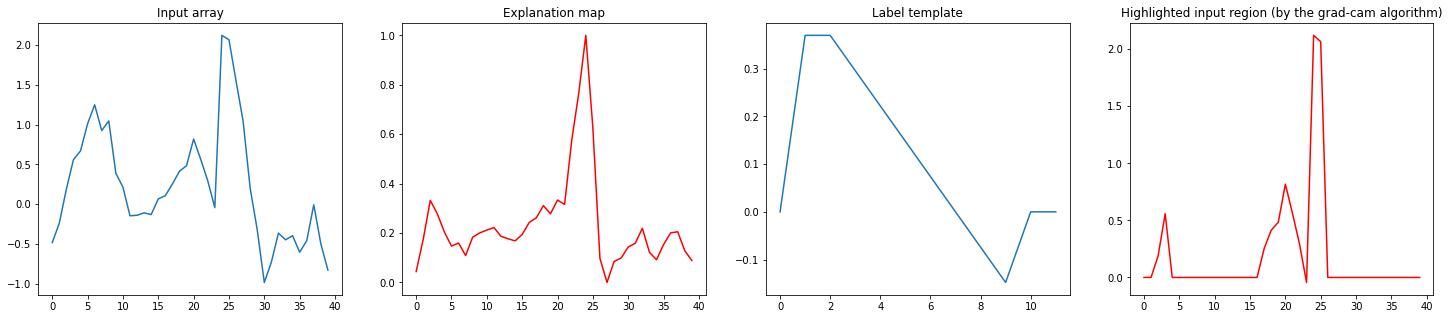

In [ ]:
threshold_cam = np.sort(explanation_cam)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation_cam, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(explanation_cam>threshold_cam)), 'r')
plt.title('Highlighted input region (by the grad-cam algorithm)')

# Task 2-2a (1): Implementing Grad-CAM++ in Python

In [ ]:
# this code is modified from the grad_cam() in the given xai_utils.py

import tensorflow as tf

def grad_cam_plus_plus(input_model, image, layer_name):
  # same as grad_cam
  cls = np.argmax(input_model.predict(image)) # class label
  y_c = input_model.output
  conv_output = input_model.get_layer(layer_name).output
  feedforward1 = keras.models.Model([input_model.input], [conv_output, y_c])

  # calculate the derivatives
  with tf.GradientTape() as tape1:
        with tf.GradientTape() as tape2:
            with tf.GradientTape() as tape3:
              ff_results=feedforward1([image])
              all_fmap_masks, predictions = ff_results[0], ff_results[-1]
              loss = predictions[:, cls]
              first_grad = tape3.gradient(loss, all_fmap_masks)
            second_grad = tape2.gradient(first_grad, all_fmap_masks)
        third_grad = tape1.gradient(second_grad, all_fmap_masks)

  g_sum = np.sum(all_fmap_masks, axis=(0,1))
  numerator = second_grad[0]
  denominator = second_grad[0]*2 + third_grad[0]*g_sum
  denominator = np.where(denominator != 0, denominator, 1e-10)
  a = numerator/denominator
  ac = np.sum(a, axis=(0,1))
  a = a / ac
  w = np.maximum(first_grad[0], 0)
  lw = np.sum(w*a, axis=(0,1))
  cam = np.sum(lw*all_fmap_masks[0], axis=1)
  cam = np.maximum(cam, 0) # ReLU
  cam = cam / np.max(cam)

  return cam

In [ ]:
index = int(np.floor(np.random.rand()*1000))
print(index)
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
print(input.shape)
label = y_test[index]
print(label)
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

912
(1, 40, 1)
3
Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 0.99996626


In [ ]:
explanation_plus_plus = grad_cam_plus_plus(model, input, 'conv1d_2')
explanation_plus_plus

array([0.10072318, 0.15370023, 0.18199158, 0.18539163, 0.20875663,
       0.23561011, 0.44255638, 0.5930999 , 0.7821047 , 0.97843534,
       1.        , 0.7477542 , 0.73743516, 0.47465828, 0.33426985,
       0.29833233, 0.25194132, 0.16359647, 0.1410623 , 0.16677852,
       0.18245162, 0.15542407, 0.13148853, 0.13465883, 0.14916325,
       0.17770305, 0.1647873 , 0.18900727, 0.321064  , 0.46014985,
       0.60238475, 0.5502878 , 0.37459958, 0.18540221, 0.21912952,
       0.25466543, 0.32814223, 0.3550972 , 0.4118361 , 0.36803755],
      dtype=float32)

Text(0.5, 1.0, 'Highlighted input region (by the grad-cam++ algorithm)')

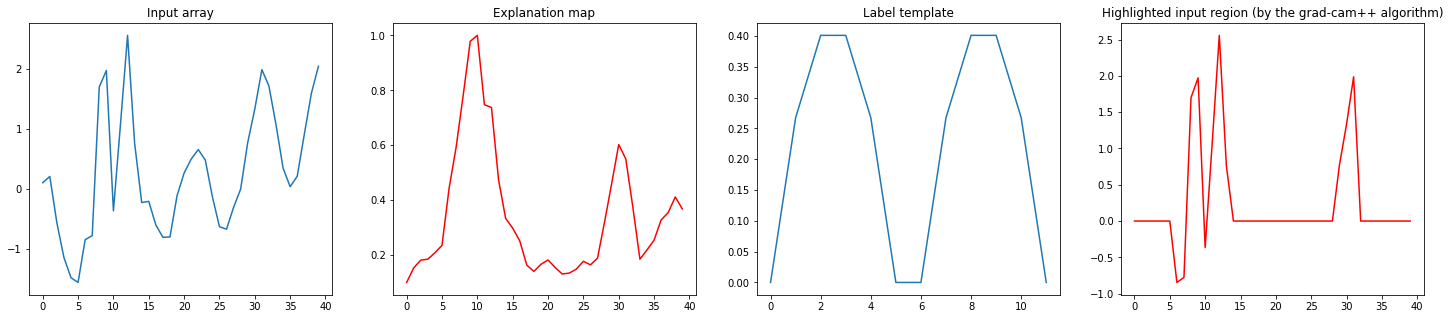

In [ ]:
threshold_plus_plus = np.sort(explanation_plus_plus)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation_plus_plus, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(explanation_plus_plus>threshold_plus_plus)), 'r')
plt.title('Highlighted input region (by the grad-cam++ algorithm)')

# Task 2-2a (2): Implementing LIME in Python

In this section, because the code from the original paper is huge, so we decided to use the LIME library and extract the map ourselves.

In [ ]:
!pip install lime
from lime import lime_tabular

     |████████████████████████████████| 275 kB 9.1 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=c4411c7183ae4cd2b4249b8e7543a0749578659262087de022020e1be1c02031
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [ ]:
index = int(np.floor(np.random.rand()*1000))
print(index)
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
print(input.shape)
label = y_test[index]
print(label)
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

404
(1, 40, 1)
6
Correct digit: 6
Predicted digit: 6
Confidence score for the correct label: 0.9985794


In [ ]:
y_test.shape

(1000,)

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(x_train.reshape((4000,40)), mode='classification', categorical_features=np.argmax(y_train, axis=1))
exp = explainer.explain_instance(input.reshape((40,)).ravel(), model.predict, num_features=40)

lst = exp.as_list()
explanation_lime = []
for i in range(len(lst)):
  explanation_lime.append(lst[i][1])
explanation_lime = np.array(explanation_lime)
explanation_lime.shape

(40,)

Text(0.5, 1.0, 'Highlighted input region (by the LIME algorithm)')

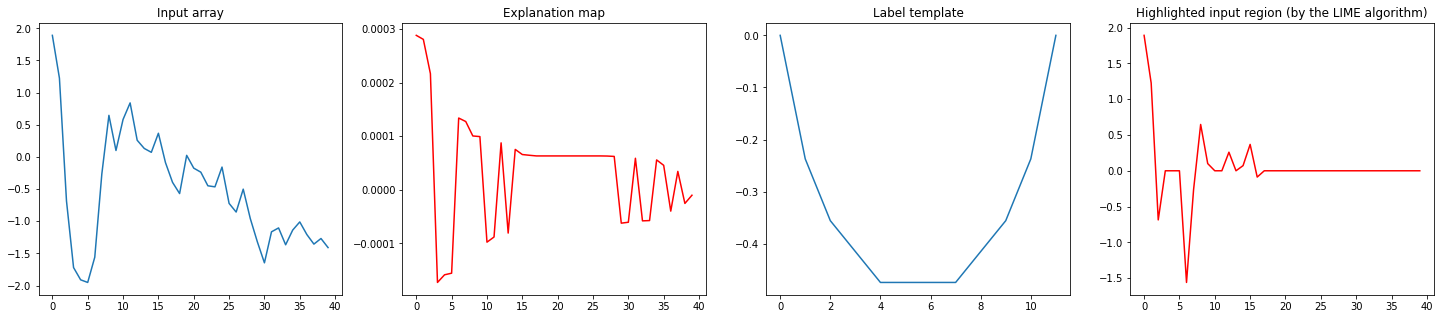

In [ ]:
threshold_lime = np.sort(explanation_lime)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation_lime, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(explanation_lime>threshold_lime)), 'r')
plt.title('Highlighted input region (by the LIME algorithm)')

In [ ]:
exp.show_in_notebook()

# Task 2-b: Qualitatively report the explanation maps you achieved and compare them with the templates presented for each of the digits. Discuss your results. Do you think the highlighted region is similar to the template corresponding to the digit predicted by your model? Do you think the explanation map shows the local behavior of the model well? [2 Marks]

In this section, we will analyze the explanation map generated by SISE, Grad-CAM, Grad-CAM++, and LIME.

SISE:

In our experiment, we run SISE not only on the last conv layer, but also run it on all three conv layers. Overall, the explanation map generated by SISE on all three layers are consistent. The set of graphs on the first row shows the explanation in the first conv layer, the set of graphs on the second row shows the explanation in the second conv layer, and the last row shows the explanation map in the final conv layer. Comparing the explanation maps with the template, the most significant shape of the explanation map (peaks) look similar (but not identical) to the template. The explanation map was able to represent the shape in the template, this can also be reflected from the input array. The peaks in the input were all preserved and the rest were all suppressed in the explanation map. Moreover, the highlighted region of the input looks exactly like the template in all conv layers. Of course, there are still some noise in the highlighted region got captured, but the highlighted region was able to represent the most significant region of the input, which means the explanation map generated by SISE is sufficient enough to show the model's local behavior.

Grad-CAM:

Because we use an improved Grad-CAM, namely Grad-CAM++ as our method, we need to first understand how Grad-CAM performs. Therefore, we will compare the explanation map of Grad-CAM and Grad-CAM++ in this section. First, looking at the explanation map generated by Grad-CAM, Overall, the explanation map looks similar to the template. Although the shape in the explanation map does not look identical to the template, one can conclude that the general shape is correct by inspection. Comparing the explanation map to the input array, it is obvious that the highest peak that has the most representitive shape as the template has been captured, which is shown in the highlighted region. Moreover, the highlighted region looks similar to the template, at the highest peak. In addition, we have also tried running Grad-CAM on the rest con layers, but somehow it did not work. We believe this is intended as the original paper used Grad-CAM only on the last conv layer. Concluding from all findings, overall, Grad-CAM well explained the local behavior of the model, but only in the last conv layer.

Grad-CAM++:

Grad-CAM++ is the first method that we selected. Because it is an improved Grad-CAM, we expect it to behave better than Grad-CAM. First looking at thre explanation map, it can be concluded that the general shape of the explanation map looks almost identical to the template. The digit displayed here is 3, and one can clearly see there is a 3 in the explanation map. Because the model is  99.8% confident that the digit is 3, it means the shape of the explanation map must be close to a perfect 3. However, looking at the highlighted input, we noticed that some of the noises have also been highlighted which makes it does not look like a perfect 3. We speculate the reason is that there are multiple regions in the input that have the same or a simialr shape as the template, so the explanation map captures all instances. Remember that Grad-CAM++ fixed the problem where Grad-CAM cannot capture multiple occurrences of the same class, so we believe this behavior is also reasonable. Overall, Grad-CAM++ well explain the model's local behavior. Additionally, when there are multiple regions in the input look similar to the template (multiple occurrences), Grad-CAM++ was still able to produce the correct explanation map.

LIME:

LIME is the second method that we selected, and it belongs to a different family than that of Grad-CAM and Grad-CAM++. Looking at the explanation map, it can be concluded that LIME also captured multiple occurrences of the same shape of the template, and it was able to make the correct explanation by looking at the prediction probability generated by LIME's built-in show_in_notebook() function. However, the highlighted region has relatively high noise involved compared to other methods. Only a section of the highted region matched the template. Moreover, during our experiments, we found that LIME is the least stable methods among the four. After searching some online resources, it seems like many have reported the instability of LIME. We speculate that the instability came from the sampling process. Since there is no correction between the features, the randomly sampled points might performed pooly in the later analyses. Overall, for most of the time, LIME well explained the model's local behavior. Therefore, we believe that LIME can still be used as a trustable explanation method.

## Quantitative evaluation

In [ ]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.3):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [ ]:
drop_rate = 0.
for index in range(1000):
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  label = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())

  explanation_map = SISE(input, model, label, layers=[['conv1d_2']], grad_thr=0.)
  drop_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, label, frac=0.3)[0]
drop_rate /= 1000

In [ ]:
increase_rate = 0.
for index in range(1000):
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  label = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())

  explanation_map = SISE(input, model, label, layers=[['conv1d_2']], grad_thr=0.)
  increase_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, label, frac=0.3)[1]
increase_rate /= 1000

In [ ]:
drop_rate # SISE drop_rate

0.15833578925994168

In [ ]:
increase_rate # SISE increase_rate

0.412

In [ ]:
drop_rate = 0.
for index in range(1000):
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  label = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())

  explanation_map = grad_cam(model, input, 'conv1d_2')
  explanation_map = explanation_map.reshape((40,1))
  drop_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, label, frac=0.3)[0]
drop_rate /= 1000

/content/drive/MyDrive/Colab Notebooks/1512/xai_utils.py:363: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()


In [ ]:
increase_rate = 0.
for index in range(1000):
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  label = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())

  explanation_map = grad_cam(model, input, 'conv1d_2')
  explanation_map = explanation_map.reshape((40,1))
  increase_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, label, frac=0.3)[1]
increase_rate /= 1000

/content/drive/MyDrive/Colab Notebooks/1512/xai_utils.py:363: RuntimeWarning: invalid value encountered in true_divide
  cam = cam / cam.max()


In [ ]:
drop_rate # Grad-CAM drop rate

0.37810958087111857

In [ ]:
increase_rate # Grad-CAM increase_rate

0.367

In [ ]:
drop_rate = 0.
for index in range(1000):
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  label = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())

  explanation_map = grad_cam_plus_plus(model, input, 'conv1d_2')
  explanation_map = explanation_map.reshape((40,1))
  drop_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, label, frac=0.3)[0]
drop_rate /= 1000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
increase_rate = 0.
for index in range(1000):
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  label = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())

  explanation_map = grad_cam_plus_plus(model, input, 'conv1d_2')
  explanation_map = explanation_map.reshape((40,1))
  increase_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, label, frac=0.3)[1]
increase_rate /= 1000

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


In [ ]:
drop_rate # Grad-CAM++ drop rate

0.2340206965885752

In [ ]:
increase_rate # Grad-CAM++ increase_rate

0.361

In [ ]:
explainer = lime_tabular.LimeTabularExplainer(x_train.reshape((4000,40)), mode='classification', categorical_features=np.argmax(y_train, axis=1))

In [ ]:
# somehow LIME takes around 40 minutes to explain the entire test set.

drop_rate = 0.
for index in range(1000):
  input = np.expand_dims(x_test[index], axis=0)
  label = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())
  exp = explainer.explain_instance(input.reshape((40,)).ravel(), model.predict, num_features=40)

  lst = exp.as_list()
  explanation_lime = []
  for i in range(len(lst)):
    explanation_lime.append(lst[i][1])
  explanation_lime = np.array(explanation_lime)
  explanation_map = explanation_lime.reshape((40,1))

  drop_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, label, frac=0.3)[0]
drop_rate /= 1000

In [ ]:
# somehow LIME takes around 40 minutes to explain the entire test set.

increase_rate = 0.
for index in range(1000):
  input = np.expand_dims(x_test[index], axis=0)
  label = np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())
  exp = explainer.explain_instance(input.reshape((40,)).ravel(), model.predict, num_features=40)
  
  lst = exp.as_list()
  explanation_lime = []
  for i in range(len(lst)):
    explanation_lime.append(lst[i][1])
  explanation_lime = np.array(explanation_lime)
  explanation_map = explanation_lime.reshape((40,1))

  increase_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, label, frac=0.3)[1]
increase_rate /= 1000

In [ ]:
drop_rate # LIME drop rate

0.7259150118226313

In [ ]:
increase_rate # LIME increase rate

0.081

concluding from the experiments above, it can be concluded that LIME does not work well on the entire test set. The drop rate is high and the increase_rate is low. LIME doesn't perform well comparing to the others. Grad-CAM++ performs better than Grad-CAM. This is expected because Grad-CAM++ is an improved Grad-CAM.